# Exercise 1: t-SNE

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically. 
* Failure to comply with the following instructions will result in a significant penalty. 
* Appeals regarding your failure to read these instructions will be denied. 
* Kind reminder: the homework assignments contribute 60% of the final grade.


## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
---

## Please sign that you have read and understood the instructions: 

316492776
318900016

---
---


In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from tqdm.auto import tqdm

np.random.seed(42)

/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Design your algorithm
Make sure to describe the algorithm, its limitations, and describe use-cases.

# Your implementations
You may add new cells, write helper functions or test code as you see fit.
Please use the cell below and include a description of your implementation.
Explain code design consideration, algorithmic choices and any other details you think is relevant to understanding your implementation.
Failing to explain your code will lead to point deductions.

In [97]:
class CustomTSNE:
    def __init__(self, perplexity=30.0, n_components=2, n_iter=1000, learning_rate=200.0):
        self.perplexity = perplexity
        self.n_components = n_components
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        # Note: You may add more attributes
        self.n_iter_without_progress = 300  # TODO
        self.min_iter = n_iter // 10  # TODO
        self.sigma = 1  # TODO
        self.verbose = True  # TODO

    def fit_transform(self, X):
        # Part 1: Implementing t-SNE

        # Step 1: Compute pairwise affinities in the original space with a Gaussian distribution
        # Your code here
        # Implementation is according to slides 61-66
        N = len(X)
        X_dists = pdist(X)
        X_dists = -X_dists**2 / (2*self.sigma**2)
        X_dists = np.exp(X_dists)
        X_dists = squareform(X_dists)  # diagonal is 0
        n_neighbors = min(N-1, int(self.perplexity))
        n_nearest_indexes = np.argsort(X_dists, axis=1)[
            :, 1:n_neighbors+1]  # +1 to remove i=j
        X_dists = np.take_along_axis(X_dists, n_nearest_indexes, axis=1)
        p_ij = X_dists / np.sum(X_dists)  # normalize to a probabilty

        Y = np.random.random((N, self.n_components))

        best_i, best_C = -1, np.inf
        for i in tqdm(range(self.n_iter), disable=not self.verbose):
            Y_diff = Y[:, np.newaxis, :] - Y[n_nearest_indexes]
            Y_dists = np.linalg.norm(Y_diff, axis=-1)
            Y_dists = 1+Y_dists**2
            Y_dists = Y_dists ** -1
            q_ij = Y_dists / np.sum(Y_dists)  # normalize to a probabilty

            C = p_ij * np.log(p_ij/q_ij)
            C = np.sum(C)
            if self.verbose:
                print(f"After {i} iterations, {C=}")
            if C < best_C:
                best_i, best_C = i, C
            if i > self.min_iter:
                if best_i + self.n_iter_without_progress < i:
                    if self.verbose:
                        print(
                            f"C has not improved for {self.n_iter_without_progress} steps. Stopping early.")
                    return Y

            grad_C_yi = 4 * \
                np.sum((p_ij - q_ij)[..., np.newaxis] *
                       Y_diff * Y_dists[..., np.newaxis], axis=1)

            Y -= self.learning_rate * grad_C_yi
            # TODO: add early stopping
        # Return Y, the 2D representation of the input data
        return Y

    # Part 2: Transformation of New Data Points
    def transform(self, X_original, Y_original, X_new):
        n_neighbors = min(N-1, int(self.perplexity))
        Y_new = []

        # Added weights to the distances as following: [1, 1/2, 1/3, 1/4.... 1/n]
        # The minimal distance get's the highest weight, and the weight is reduced as the distance increasing
        W_arr = np.power(np.arange(1, n_neighbors + 1, dtype=float), -1)
        
        for i in range(X_new.shape[0]):
            # Calculate the distance array for each one of the test values
            d = cdist(X_new[i].reshape(1, -1),X_original)

            # Sort the indices of the distances from minimal to maximal while limit just to the n_neighbors distances
            d_argsort = np.argsort(d, axis=1).flatten()[:n_neighbors]

            # Find the average location based on the indices of the distances, while the distances are weighted (Minimal distance -> max weight)
            dest_value = np.average(Y_original[d_argsort], axis=0, weights=W_arr)
        
            Y_new.append(dest_value)
        
        return np.array(Y_new)


# Load data
Please use the cell below to discuss your dataset choice and why it is appropriate (or not) for this algorithm.

We chose to use MNIST dataset to our algorithm

We've found that this dataset is the most simple one and most used in PCA and T-SNE algorithms.
It's usage is about encoding a digit in an image (Assuming the digit is shown as pixels just like one takes a photo of a car plate), and each image is labeled by it's digit value

Using T-SNE algorithm, we can find the relationship and the distances between the images with a very clear and visual way, while since we have just 10 digits in MNIST (0-9), we can classify the images into 10 groups and show in 2D dimension the relationship and distance between them

We split the dataset into train (80%) and test (20%) while the dataset contains 10,000 examples in total

Since the image values are described by RGB codes (0 -> white to 255 -> black), the digits should be represented as black while the background as white, but in fact the digits are in various range of colors between white and black (gray, dark gray. etc). Then, in order to reduce errors since the colors distribution, we want to normalize it so the digit will be represented with one single RGB code

In [87]:
# Loading the data into train / test datasets

dataset = pd.read_csv("./Dataset/mnist_dataset.csv")

# The X axis is the pixels RGB matrix that represents the digit
X = dataset.loc[:,'1x1':].values

# The y axis is the actual digit that the the pixels matrix represents
y = dataset.loc[:,'label'].values

X_train, X_test, label_train, label_test = train_test_split(
    X, y, test_size=0.2)

# Normalizing the RGB codes by dividing it to the max RGB value.
X_train_normalized_opt1 = X_train / 255
X_test_normalized_opt1 = X_test / 255

# Normalizing the RGB codes by standard scaler
sc = StandardScaler()
X_train_normalized_opt2 = sc.fit_transform(X_train)
X_test_normalized_opt2 = sc.transform(X_test)

In [88]:
dataset.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
X_train.shape

(8000, 784)

In [90]:
X_train_normalized_opt1.shape

(8000, 784)

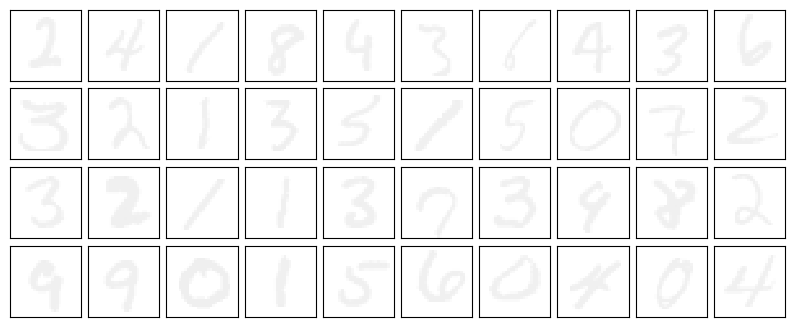

In [91]:
# This is a ploting of sample train data

fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train_normalized_opt1[i].reshape(28, 28),
              cmap='binary', interpolation='nearest',
              clim=(0, 16))

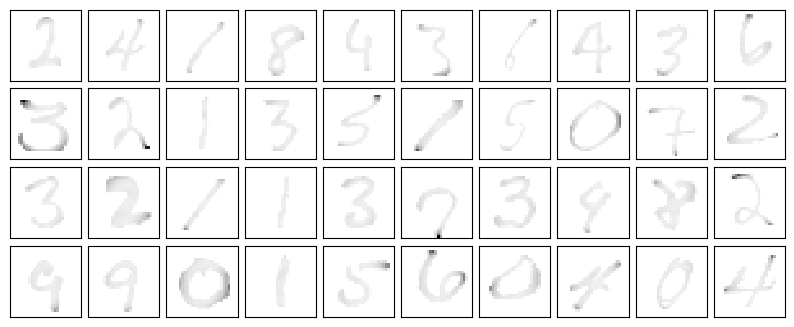

In [92]:
# This is a ploting of sample train data

fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train_normalized_opt2[i].reshape(28, 28),
              cmap='binary', interpolation='nearest',
              clim=(0, 16))

# t-SNE demonstration 
Demonstrate your t-SNE implementation.

Add plots and figures. The code below is just to help you get started, and should not be your final submission.

Please use the cell below to describe your results and tests.

Describe the difference between your implementation and the sklearn implementation. Hint: you can look at the documentation.

  0%|                                            | 2/1000 [00:00<01:09, 14.44it/s]

After 0 iterations, C=np.float64(4.924065598148857)
After 1 iterations, C=np.float64(6.527638208855722)
After 2 iterations, C=np.float64(6.107738895956532)
After 3 iterations, C=np.float64(5.681656515250379)


  1%|▎                                           | 6/1000 [00:00<01:03, 15.64it/s]

After 4 iterations, C=np.float64(6.298840836176891)
After 5 iterations, C=np.float64(5.9560957097724945)
After 6 iterations, C=np.float64(5.851581195451509)
After 7 iterations, C=np.float64(5.968807247331482)


  1%|▍                                          | 10/1000 [00:00<01:02, 15.89it/s]

After 8 iterations, C=np.float64(6.4180514502051125)
After 9 iterations, C=np.float64(6.342091577383641)
After 10 iterations, C=np.float64(5.980884501469218)
After 11 iterations, C=np.float64(6.241234964280203)


  1%|▌                                          | 14/1000 [00:00<01:01, 15.97it/s]

After 12 iterations, C=np.float64(5.925093087741837)
After 13 iterations, C=np.float64(5.720676336115773)
After 14 iterations, C=np.float64(6.063502689890929)
After 15 iterations, C=np.float64(6.191014055152695)


  2%|▊                                          | 18/1000 [00:01<01:01, 16.01it/s]

After 16 iterations, C=np.float64(5.807982410591911)
After 17 iterations, C=np.float64(5.7869953297358725)
After 18 iterations, C=np.float64(5.712533502144025)
After 19 iterations, C=np.float64(6.018120790806075)


  2%|▉                                          | 22/1000 [00:01<01:01, 15.99it/s]

After 20 iterations, C=np.float64(5.77831909484886)
After 21 iterations, C=np.float64(5.791763192509068)
After 22 iterations, C=np.float64(5.622547918960612)
After 23 iterations, C=np.float64(5.890558659499794)


  3%|█                                          | 26/1000 [00:01<01:00, 16.01it/s]

After 24 iterations, C=np.float64(5.738399986059753)
After 25 iterations, C=np.float64(5.715316019785426)
After 26 iterations, C=np.float64(5.63700304197391)
After 27 iterations, C=np.float64(5.647464717319365)


  3%|█▎                                         | 30/1000 [00:01<01:00, 15.95it/s]

After 28 iterations, C=np.float64(5.476433225537157)
After 29 iterations, C=np.float64(5.683640204312593)
After 30 iterations, C=np.float64(5.450654803814049)
After 31 iterations, C=np.float64(5.7572552878215735)


  3%|█▍                                         | 34/1000 [00:02<01:01, 15.66it/s]

After 32 iterations, C=np.float64(5.457682256422843)
After 33 iterations, C=np.float64(5.760808252360577)
After 34 iterations, C=np.float64(5.538673373622156)
After 35 iterations, C=np.float64(5.546682330511934)


  4%|█▋                                         | 38/1000 [00:02<01:00, 15.80it/s]

After 36 iterations, C=np.float64(5.4503595064951185)
After 37 iterations, C=np.float64(5.668123993823896)
After 38 iterations, C=np.float64(5.6106604504365505)
After 39 iterations, C=np.float64(5.704501937291239)


  4%|█▊                                         | 42/1000 [00:02<01:00, 15.90it/s]

After 40 iterations, C=np.float64(5.243718991404017)
After 41 iterations, C=np.float64(5.650816018985715)
After 42 iterations, C=np.float64(5.622006465167392)
After 43 iterations, C=np.float64(5.393889474019444)


  5%|█▉                                         | 46/1000 [00:02<00:59, 15.97it/s]

After 44 iterations, C=np.float64(5.382140354087216)
After 45 iterations, C=np.float64(5.397973482635088)
After 46 iterations, C=np.float64(5.630844764346361)
After 47 iterations, C=np.float64(5.425988769467432)


  5%|██▏                                        | 50/1000 [00:03<00:59, 16.00it/s]

After 48 iterations, C=np.float64(5.331871642211766)
After 49 iterations, C=np.float64(5.560117245431737)
After 50 iterations, C=np.float64(5.147105368861861)
After 51 iterations, C=np.float64(5.5682741977472014)


  5%|██▎                                        | 54/1000 [00:03<00:59, 15.97it/s]

After 52 iterations, C=np.float64(5.408938206593323)
After 53 iterations, C=np.float64(5.420589565714791)
After 54 iterations, C=np.float64(5.229412177451904)
After 55 iterations, C=np.float64(5.176150695179288)


  6%|██▍                                        | 58/1000 [00:03<00:58, 15.99it/s]

After 56 iterations, C=np.float64(5.522219855318457)
After 57 iterations, C=np.float64(5.356431781784257)
After 58 iterations, C=np.float64(5.398431799139283)
After 59 iterations, C=np.float64(5.268447226118437)


  6%|██▋                                        | 62/1000 [00:03<00:58, 16.01it/s]

After 60 iterations, C=np.float64(5.452226254055218)
After 61 iterations, C=np.float64(5.3996013833172185)
After 62 iterations, C=np.float64(5.1530762456833274)
After 63 iterations, C=np.float64(5.3439848972341775)


  7%|██▊                                        | 66/1000 [00:04<00:58, 16.01it/s]

After 64 iterations, C=np.float64(5.273597114792464)
After 65 iterations, C=np.float64(5.171013381168557)
After 66 iterations, C=np.float64(5.466100254091989)
After 67 iterations, C=np.float64(5.126973043739672)


  7%|███                                        | 70/1000 [00:04<00:58, 15.87it/s]

After 68 iterations, C=np.float64(5.398590051211653)
After 69 iterations, C=np.float64(5.270615552496012)
After 70 iterations, C=np.float64(5.254149188352197)
After 71 iterations, C=np.float64(5.1812259043218445)


  7%|███▏                                       | 74/1000 [00:04<00:58, 15.76it/s]

After 72 iterations, C=np.float64(5.280199922109014)
After 73 iterations, C=np.float64(5.121990940340964)
After 74 iterations, C=np.float64(5.358988044755993)
After 75 iterations, C=np.float64(5.067218478645136)


  8%|███▎                                       | 78/1000 [00:04<00:59, 15.56it/s]

After 76 iterations, C=np.float64(5.1983450250613465)
After 77 iterations, C=np.float64(5.228594060861188)
After 78 iterations, C=np.float64(5.260713475748975)
After 79 iterations, C=np.float64(5.003191216641209)


  8%|███▌                                       | 82/1000 [00:05<00:59, 15.49it/s]

After 80 iterations, C=np.float64(5.211816915654264)
After 81 iterations, C=np.float64(5.084102179789774)
After 82 iterations, C=np.float64(5.242030082406015)
After 83 iterations, C=np.float64(5.029106291355097)


  9%|███▋                                       | 86/1000 [00:05<00:58, 15.63it/s]

After 84 iterations, C=np.float64(5.1693731144526955)
After 85 iterations, C=np.float64(5.192119591993482)
After 86 iterations, C=np.float64(5.122606777079977)
After 87 iterations, C=np.float64(5.011112847394933)


  9%|███▊                                       | 90/1000 [00:05<00:57, 15.71it/s]

After 88 iterations, C=np.float64(5.02022989987032)
After 89 iterations, C=np.float64(5.114293291155909)
After 90 iterations, C=np.float64(5.199462689789855)
After 91 iterations, C=np.float64(5.009218897844194)


  9%|████                                       | 94/1000 [00:05<00:57, 15.73it/s]

After 92 iterations, C=np.float64(5.031425691565407)
After 93 iterations, C=np.float64(5.111790253365031)
After 94 iterations, C=np.float64(5.000898481130063)
After 95 iterations, C=np.float64(5.085220469420494)


 10%|████▏                                      | 98/1000 [00:06<00:57, 15.74it/s]

After 96 iterations, C=np.float64(5.183031314564684)
After 97 iterations, C=np.float64(5.076947759740087)
After 98 iterations, C=np.float64(5.1790235676305265)
After 99 iterations, C=np.float64(5.002772593827258)


 10%|████▎                                     | 102/1000 [00:06<00:56, 15.82it/s]

After 100 iterations, C=np.float64(5.020689352381242)
After 101 iterations, C=np.float64(5.169240552822101)
After 102 iterations, C=np.float64(5.073804086514552)
After 103 iterations, C=np.float64(5.124092424098875)


 11%|████▍                                     | 106/1000 [00:06<00:56, 15.79it/s]

After 104 iterations, C=np.float64(4.9693332208324845)
After 105 iterations, C=np.float64(5.046096507650064)
After 106 iterations, C=np.float64(5.131353626197705)
After 107 iterations, C=np.float64(5.021430472931061)


 11%|████▌                                     | 110/1000 [00:06<00:56, 15.83it/s]

After 108 iterations, C=np.float64(5.0311548417788305)
After 109 iterations, C=np.float64(5.076263728399355)
After 110 iterations, C=np.float64(4.949152473708799)
After 111 iterations, C=np.float64(5.027820990139562)


 11%|████▊                                     | 114/1000 [00:07<00:55, 15.93it/s]

After 112 iterations, C=np.float64(5.074349252860999)
After 113 iterations, C=np.float64(4.977308088560513)
After 114 iterations, C=np.float64(5.03216752296184)
After 115 iterations, C=np.float64(4.950607095472585)


 12%|████▉                                     | 118/1000 [00:07<00:56, 15.52it/s]

After 116 iterations, C=np.float64(5.047295805283601)
After 117 iterations, C=np.float64(4.930400383562224)
After 118 iterations, C=np.float64(5.084540713469663)
After 119 iterations, C=np.float64(4.8941436261280975)


 12%|█████                                     | 122/1000 [00:07<00:56, 15.62it/s]

After 120 iterations, C=np.float64(4.9783181433823005)
After 121 iterations, C=np.float64(5.0143358836097525)
After 122 iterations, C=np.float64(4.927946050953589)
After 123 iterations, C=np.float64(4.963424855175294)


 13%|█████▎                                    | 126/1000 [00:07<00:55, 15.68it/s]

After 124 iterations, C=np.float64(4.911536748923223)
After 125 iterations, C=np.float64(5.035281893440341)
After 126 iterations, C=np.float64(4.876974525947002)
After 127 iterations, C=np.float64(4.905002204471014)


 13%|█████▍                                    | 130/1000 [00:08<00:55, 15.71it/s]

After 128 iterations, C=np.float64(5.016725618099863)
After 129 iterations, C=np.float64(4.8601957187580025)
After 130 iterations, C=np.float64(4.873512178604065)
After 131 iterations, C=np.float64(5.023575427736431)


 13%|█████▋                                    | 134/1000 [00:08<00:54, 15.75it/s]

After 132 iterations, C=np.float64(4.880911873045048)
After 133 iterations, C=np.float64(4.855620685824397)
After 134 iterations, C=np.float64(4.917400533983351)
After 135 iterations, C=np.float64(4.919867840809545)


 14%|█████▊                                    | 138/1000 [00:08<00:54, 15.75it/s]

After 136 iterations, C=np.float64(4.9313283016268405)
After 137 iterations, C=np.float64(4.875736894226317)
After 138 iterations, C=np.float64(4.946766276639211)
After 139 iterations, C=np.float64(4.834495626637961)


 14%|█████▉                                    | 142/1000 [00:09<00:58, 14.60it/s]

After 140 iterations, C=np.float64(4.863684306997758)
After 141 iterations, C=np.float64(4.936437153430314)
After 142 iterations, C=np.float64(4.81588029211402)
After 143 iterations, C=np.float64(4.841174240248529)


 15%|██████▏                                   | 146/1000 [00:09<00:56, 15.24it/s]

After 144 iterations, C=np.float64(4.935632421106024)
After 145 iterations, C=np.float64(4.79975587582817)
After 146 iterations, C=np.float64(4.813684325918223)
After 147 iterations, C=np.float64(4.917952814550907)


 15%|██████▎                                   | 150/1000 [00:09<00:54, 15.62it/s]

After 148 iterations, C=np.float64(4.80124825157607)
After 149 iterations, C=np.float64(4.810010899069544)
After 150 iterations, C=np.float64(4.888768360744108)
After 151 iterations, C=np.float64(4.787238057178986)


 15%|██████▍                                   | 154/1000 [00:09<00:53, 15.81it/s]

After 152 iterations, C=np.float64(4.799853282594315)
After 153 iterations, C=np.float64(4.877191115354223)
After 154 iterations, C=np.float64(4.7542636251568124)
After 155 iterations, C=np.float64(4.775796988345413)


 16%|██████▋                                   | 158/1000 [00:10<00:54, 15.42it/s]

After 156 iterations, C=np.float64(4.832451583230029)
After 157 iterations, C=np.float64(4.753457798631859)
After 158 iterations, C=np.float64(4.797899955239201)


 16%|██████▊                                   | 162/1000 [00:10<00:54, 15.24it/s]

After 159 iterations, C=np.float64(4.767897090533353)
After 160 iterations, C=np.float64(4.84245612519404)
After 161 iterations, C=np.float64(4.726556660872006)
After 162 iterations, C=np.float64(4.730050601500032)


 17%|██████▉                                   | 166/1000 [00:10<00:53, 15.48it/s]

After 163 iterations, C=np.float64(4.783391293642358)
After 164 iterations, C=np.float64(4.736932649193963)
After 165 iterations, C=np.float64(4.803509377488629)
After 166 iterations, C=np.float64(4.7011792011085305)


 17%|███████▏                                  | 170/1000 [00:10<00:53, 15.62it/s]

After 167 iterations, C=np.float64(4.71521553724495)
After 168 iterations, C=np.float64(4.728907159466004)
After 169 iterations, C=np.float64(4.786320345059856)
After 170 iterations, C=np.float64(4.693405054752634)


 17%|███████▎                                  | 174/1000 [00:11<00:52, 15.62it/s]

After 171 iterations, C=np.float64(4.704942457305184)
After 172 iterations, C=np.float64(4.718403381170861)
After 173 iterations, C=np.float64(4.762524387194948)
After 174 iterations, C=np.float64(4.704324596279824)


 18%|███████▍                                  | 178/1000 [00:11<00:52, 15.67it/s]

After 175 iterations, C=np.float64(4.762584625117275)
After 176 iterations, C=np.float64(4.689324155830817)
After 177 iterations, C=np.float64(4.711701647704817)
After 178 iterations, C=np.float64(4.704761767091276)


 18%|███████▋                                  | 182/1000 [00:11<00:52, 15.68it/s]

After 179 iterations, C=np.float64(4.766940752253739)
After 180 iterations, C=np.float64(4.672471511018571)
After 181 iterations, C=np.float64(4.677014919006806)
After 182 iterations, C=np.float64(4.695153845727088)


 19%|███████▊                                  | 186/1000 [00:11<00:51, 15.70it/s]

After 183 iterations, C=np.float64(4.669464449629192)
After 184 iterations, C=np.float64(4.688880715515231)
After 185 iterations, C=np.float64(4.74159698610005)
After 186 iterations, C=np.float64(4.656786815416268)


 19%|███████▉                                  | 190/1000 [00:12<00:51, 15.70it/s]

After 187 iterations, C=np.float64(4.659802843232005)
After 188 iterations, C=np.float64(4.66365685448962)
After 189 iterations, C=np.float64(4.678015324944909)
After 190 iterations, C=np.float64(4.658903617838155)


 19%|████████▏                                 | 194/1000 [00:12<00:51, 15.62it/s]

After 191 iterations, C=np.float64(4.697057406473984)
After 192 iterations, C=np.float64(4.65042479308521)
After 193 iterations, C=np.float64(4.650787343791674)
After 194 iterations, C=np.float64(4.651965803738047)


 20%|████████▎                                 | 198/1000 [00:12<00:51, 15.69it/s]

After 195 iterations, C=np.float64(4.693427821212802)
After 196 iterations, C=np.float64(4.641300146284021)
After 197 iterations, C=np.float64(4.659970757582456)
After 198 iterations, C=np.float64(4.636574371031528)


 20%|████████▍                                 | 202/1000 [00:12<00:51, 15.48it/s]

After 199 iterations, C=np.float64(4.665966725340407)
After 200 iterations, C=np.float64(4.627217290617579)
After 201 iterations, C=np.float64(4.624393689177536)
After 202 iterations, C=np.float64(4.6291055728649475)


 21%|████████▋                                 | 206/1000 [00:13<00:50, 15.63it/s]

After 203 iterations, C=np.float64(4.6209999349069895)
After 204 iterations, C=np.float64(4.630595135672091)
After 205 iterations, C=np.float64(4.62470241086582)
After 206 iterations, C=np.float64(4.646488872331497)


 21%|████████▊                                 | 210/1000 [00:13<00:50, 15.65it/s]

After 207 iterations, C=np.float64(4.615970289215802)
After 208 iterations, C=np.float64(4.615664802852674)
After 209 iterations, C=np.float64(4.624566888858735)
After 210 iterations, C=np.float64(4.606075950894943)


 21%|████████▉                                 | 214/1000 [00:13<00:50, 15.69it/s]

After 211 iterations, C=np.float64(4.613407051984847)
After 212 iterations, C=np.float64(4.62432411571894)
After 213 iterations, C=np.float64(4.654170968640805)
After 214 iterations, C=np.float64(4.604484521042018)


 22%|█████████▏                                | 218/1000 [00:13<00:49, 15.77it/s]

After 215 iterations, C=np.float64(4.604816282577716)
After 216 iterations, C=np.float64(4.613649445833651)
After 217 iterations, C=np.float64(4.599923718291183)
After 218 iterations, C=np.float64(4.608385956720006)


 22%|█████████▎                                | 222/1000 [00:14<00:49, 15.79it/s]

After 219 iterations, C=np.float64(4.6048770199245315)
After 220 iterations, C=np.float64(4.624648921974345)
After 221 iterations, C=np.float64(4.593288594601845)
After 222 iterations, C=np.float64(4.5925172587813385)


 23%|█████████▍                                | 226/1000 [00:14<00:49, 15.70it/s]

After 223 iterations, C=np.float64(4.599553749276481)
After 224 iterations, C=np.float64(4.596797058192281)
After 225 iterations, C=np.float64(4.6126312597981425)
After 226 iterations, C=np.float64(4.584092607997858)


 23%|█████████▋                                | 230/1000 [00:14<00:48, 15.75it/s]

After 227 iterations, C=np.float64(4.584382489947433)
After 228 iterations, C=np.float64(4.583161974136456)
After 229 iterations, C=np.float64(4.581450468353559)
After 230 iterations, C=np.float64(4.581305822018805)


 23%|█████████▊                                | 234/1000 [00:14<00:48, 15.77it/s]

After 231 iterations, C=np.float64(4.588515219877617)
After 232 iterations, C=np.float64(4.605673502019674)
After 233 iterations, C=np.float64(4.577282162743468)
After 234 iterations, C=np.float64(4.57544789830687)


 24%|█████████▉                                | 238/1000 [00:15<00:48, 15.76it/s]

After 235 iterations, C=np.float64(4.580047268354843)
After 236 iterations, C=np.float64(4.584925318940635)
After 237 iterations, C=np.float64(4.603016142058868)
After 238 iterations, C=np.float64(4.575365776903216)


 24%|██████████▏                               | 242/1000 [00:15<00:47, 15.80it/s]

After 239 iterations, C=np.float64(4.5772133887055935)
After 240 iterations, C=np.float64(4.590248183587891)
After 241 iterations, C=np.float64(4.567732771005149)
After 242 iterations, C=np.float64(4.566840048392422)


 25%|██████████▎                               | 246/1000 [00:15<00:50, 14.96it/s]

After 243 iterations, C=np.float64(4.571201671787229)
After 244 iterations, C=np.float64(4.581745728324447)
After 245 iterations, C=np.float64(4.566251877206576)
After 246 iterations, C=np.float64(4.572242385834633)


 25%|██████████▌                               | 250/1000 [00:15<00:49, 15.29it/s]

After 247 iterations, C=np.float64(4.569695668286507)
After 248 iterations, C=np.float64(4.583487415109177)
After 249 iterations, C=np.float64(4.558781514244619)
After 250 iterations, C=np.float64(4.556865207660939)


 25%|██████████▋                               | 254/1000 [00:16<00:48, 15.51it/s]

After 251 iterations, C=np.float64(4.557818468011684)
After 252 iterations, C=np.float64(4.558830741974843)
After 253 iterations, C=np.float64(4.559249475049156)
After 254 iterations, C=np.float64(4.56645910604575)


 26%|██████████▊                               | 258/1000 [00:16<00:47, 15.60it/s]

After 255 iterations, C=np.float64(4.556542520029867)
After 256 iterations, C=np.float64(4.563492729418204)
After 257 iterations, C=np.float64(4.5573786491664565)
After 258 iterations, C=np.float64(4.567922312902537)


 26%|███████████                               | 262/1000 [00:16<00:47, 15.68it/s]

After 259 iterations, C=np.float64(4.550046554980666)
After 260 iterations, C=np.float64(4.552008975625588)
After 261 iterations, C=np.float64(4.55347809145179)
After 262 iterations, C=np.float64(4.563525933946184)


 27%|███████████▏                              | 266/1000 [00:16<00:46, 15.68it/s]

After 263 iterations, C=np.float64(4.545746493889108)
After 264 iterations, C=np.float64(4.546206260243079)
After 265 iterations, C=np.float64(4.545143937504035)
After 266 iterations, C=np.float64(4.547985281731785)


 27%|███████████▎                              | 270/1000 [00:17<00:46, 15.71it/s]

After 267 iterations, C=np.float64(4.548587423850182)
After 268 iterations, C=np.float64(4.559633325403312)
After 269 iterations, C=np.float64(4.539049238196635)
After 270 iterations, C=np.float64(4.537655850933884)


 27%|███████████▌                              | 274/1000 [00:17<00:46, 15.76it/s]

After 271 iterations, C=np.float64(4.5381672779637166)
After 272 iterations, C=np.float64(4.538618025714638)
After 273 iterations, C=np.float64(4.537273029195542)
After 274 iterations, C=np.float64(4.539017843325345)


 28%|███████████▋                              | 278/1000 [00:17<00:45, 15.77it/s]

After 275 iterations, C=np.float64(4.540133636977822)
After 276 iterations, C=np.float64(4.549287262134067)
After 277 iterations, C=np.float64(4.532119674531473)
After 278 iterations, C=np.float64(4.531720402689615)


 28%|███████████▊                              | 282/1000 [00:17<00:45, 15.64it/s]

After 279 iterations, C=np.float64(4.532493103358678)
After 280 iterations, C=np.float64(4.535072009219142)
After 281 iterations, C=np.float64(4.533170034489264)
After 282 iterations, C=np.float64(4.53962323193681)


 29%|████████████                              | 286/1000 [00:18<00:46, 15.37it/s]

After 283 iterations, C=np.float64(4.528183773069967)
After 284 iterations, C=np.float64(4.530077101053659)
After 285 iterations, C=np.float64(4.528539541592709)
After 286 iterations, C=np.float64(4.5331527059281225)


 29%|████████████▏                             | 290/1000 [00:18<00:45, 15.55it/s]

After 287 iterations, C=np.float64(4.526500661477017)
After 288 iterations, C=np.float64(4.531002538424981)
After 289 iterations, C=np.float64(4.525448242946148)
After 290 iterations, C=np.float64(4.530643015739849)


 29%|████████████▎                             | 294/1000 [00:18<00:45, 15.68it/s]

After 291 iterations, C=np.float64(4.522382953605332)
After 292 iterations, C=np.float64(4.525509800267303)
After 293 iterations, C=np.float64(4.5221988888484885)
After 294 iterations, C=np.float64(4.526988478913319)


 30%|████████████▌                             | 298/1000 [00:19<00:44, 15.83it/s]

After 295 iterations, C=np.float64(4.51900035000415)
After 296 iterations, C=np.float64(4.5216039054751)
After 297 iterations, C=np.float64(4.518425112609866)
After 298 iterations, C=np.float64(4.522181335352626)


 30%|████████████▋                             | 302/1000 [00:19<00:43, 15.90it/s]

After 299 iterations, C=np.float64(4.5164406592240836)
After 300 iterations, C=np.float64(4.51958890556565)
After 301 iterations, C=np.float64(4.515019910041543)
After 302 iterations, C=np.float64(4.5182686976873025)


 31%|████████████▊                             | 306/1000 [00:19<00:43, 15.96it/s]

After 303 iterations, C=np.float64(4.513361807640518)
After 304 iterations, C=np.float64(4.516374200173337)
After 305 iterations, C=np.float64(4.51171633443267)
After 306 iterations, C=np.float64(4.514145055631829)


 31%|█████████████                             | 310/1000 [00:19<00:43, 15.99it/s]

After 307 iterations, C=np.float64(4.5102002454768915)
After 308 iterations, C=np.float64(4.512835388847785)
After 309 iterations, C=np.float64(4.508432512781225)
After 310 iterations, C=np.float64(4.510189170179043)


 31%|█████████████▏                            | 314/1000 [00:20<00:42, 16.02it/s]

After 311 iterations, C=np.float64(4.506972315657768)
After 312 iterations, C=np.float64(4.50865874617388)
After 313 iterations, C=np.float64(4.504904153926607)
After 314 iterations, C=np.float64(4.505880169491583)


 32%|█████████████▎                            | 318/1000 [00:20<00:42, 16.01it/s]

After 315 iterations, C=np.float64(4.503458225279509)
After 316 iterations, C=np.float64(4.503797595949685)
After 317 iterations, C=np.float64(4.5009664793505655)
After 318 iterations, C=np.float64(4.500634889782569)


 32%|█████████████▌                            | 322/1000 [00:20<00:42, 16.03it/s]

After 319 iterations, C=np.float64(4.499488675416075)
After 320 iterations, C=np.float64(4.499183029198162)
After 321 iterations, C=np.float64(4.498623741880252)
After 322 iterations, C=np.float64(4.4981849523372475)


 33%|█████████████▋                            | 326/1000 [00:20<00:42, 15.74it/s]

After 323 iterations, C=np.float64(4.497916879675223)
After 324 iterations, C=np.float64(4.496456224975948)
After 325 iterations, C=np.float64(4.4954855877332145)
After 326 iterations, C=np.float64(4.494086428757742)


 33%|█████████████▊                            | 330/1000 [00:21<00:42, 15.64it/s]

After 327 iterations, C=np.float64(4.493235533077938)
After 328 iterations, C=np.float64(4.492554508532794)
After 329 iterations, C=np.float64(4.492317244307665)
After 330 iterations, C=np.float64(4.491827774183365)


 33%|██████████████                            | 334/1000 [00:21<00:42, 15.82it/s]

After 331 iterations, C=np.float64(4.491989314531665)
After 332 iterations, C=np.float64(4.491689800135736)
After 333 iterations, C=np.float64(4.491547252194317)
After 334 iterations, C=np.float64(4.489711113347391)


 34%|██████████████▏                           | 338/1000 [00:21<00:41, 15.92it/s]

After 335 iterations, C=np.float64(4.4889565272540075)
After 336 iterations, C=np.float64(4.487420485127315)
After 337 iterations, C=np.float64(4.48655692134963)
After 338 iterations, C=np.float64(4.486031229552813)


 34%|██████████████▎                           | 342/1000 [00:21<00:41, 15.98it/s]

After 339 iterations, C=np.float64(4.48620408219837)
After 340 iterations, C=np.float64(4.485544718118223)
After 341 iterations, C=np.float64(4.485870907001063)
After 342 iterations, C=np.float64(4.485636801720075)


 35%|██████████████▌                           | 346/1000 [00:22<00:41, 15.87it/s]

After 343 iterations, C=np.float64(4.485641444655113)
After 344 iterations, C=np.float64(4.483198570350721)
After 345 iterations, C=np.float64(4.482305690643592)
After 346 iterations, C=np.float64(4.480977027241509)


 35%|██████████████▋                           | 350/1000 [00:22<00:40, 15.89it/s]

After 347 iterations, C=np.float64(4.480522462812763)
After 348 iterations, C=np.float64(4.479918443329524)
After 349 iterations, C=np.float64(4.480136398336402)
After 350 iterations, C=np.float64(4.4794893446717685)


 35%|██████████████▊                           | 354/1000 [00:22<00:40, 15.95it/s]

After 351 iterations, C=np.float64(4.48020458370775)
After 352 iterations, C=np.float64(4.479811790334408)
After 353 iterations, C=np.float64(4.479856366407091)
After 354 iterations, C=np.float64(4.476880754004885)


 36%|███████████████                           | 358/1000 [00:22<00:40, 15.97it/s]

After 355 iterations, C=np.float64(4.47592320792508)
After 356 iterations, C=np.float64(4.475112849914328)
After 357 iterations, C=np.float64(4.475318695593305)
After 358 iterations, C=np.float64(4.473939826388178)


 36%|███████████████▏                          | 362/1000 [00:23<00:39, 16.01it/s]

After 359 iterations, C=np.float64(4.474038193202923)
After 360 iterations, C=np.float64(4.474403777383239)
After 361 iterations, C=np.float64(4.4760612442079735)
After 362 iterations, C=np.float64(4.473401799845989)


 37%|███████████████▎                          | 366/1000 [00:23<00:39, 15.89it/s]

After 363 iterations, C=np.float64(4.472543599821579)
After 364 iterations, C=np.float64(4.47105211272225)
After 365 iterations, C=np.float64(4.471158427926177)
After 366 iterations, C=np.float64(4.4693500341987615)


 37%|███████████████▌                          | 370/1000 [00:23<00:39, 15.76it/s]

After 367 iterations, C=np.float64(4.469373379068347)
After 368 iterations, C=np.float64(4.469504875351623)
After 369 iterations, C=np.float64(4.471382718143056)
After 370 iterations, C=np.float64(4.4694232245818)


 37%|███████████████▋                          | 374/1000 [00:23<00:39, 15.88it/s]

After 371 iterations, C=np.float64(4.469019339039552)
After 372 iterations, C=np.float64(4.466961051855216)
After 373 iterations, C=np.float64(4.467119774532992)
After 374 iterations, C=np.float64(4.464778959185679)


 38%|███████████████▉                          | 378/1000 [00:24<00:38, 15.97it/s]

After 375 iterations, C=np.float64(4.464602327203454)
After 376 iterations, C=np.float64(4.464730824316257)
After 377 iterations, C=np.float64(4.466632717705466)
After 378 iterations, C=np.float64(4.465067538687116)


 38%|████████████████                          | 382/1000 [00:24<00:38, 16.02it/s]

After 379 iterations, C=np.float64(4.465430587000138)
After 380 iterations, C=np.float64(4.4632806456962015)
After 381 iterations, C=np.float64(4.463789092069136)
After 382 iterations, C=np.float64(4.460369394888102)


 39%|████████████████▏                         | 386/1000 [00:24<00:38, 16.03it/s]

After 383 iterations, C=np.float64(4.459811855789352)
After 384 iterations, C=np.float64(4.460717355086686)
After 385 iterations, C=np.float64(4.463193890653735)
After 386 iterations, C=np.float64(4.460377557128443)


 39%|████████████████▍                         | 390/1000 [00:24<00:38, 16.02it/s]

After 387 iterations, C=np.float64(4.460556447089363)
After 388 iterations, C=np.float64(4.459640009019499)
After 389 iterations, C=np.float64(4.461169531072786)
After 390 iterations, C=np.float64(4.455968901121347)


 39%|████████████████▌                         | 394/1000 [00:25<00:37, 16.04it/s]

After 391 iterations, C=np.float64(4.454788187907214)
After 392 iterations, C=np.float64(4.456829524973666)
After 393 iterations, C=np.float64(4.46096570856491)
After 394 iterations, C=np.float64(4.456263690275864)


 40%|████████████████▋                         | 398/1000 [00:25<00:37, 16.04it/s]

After 395 iterations, C=np.float64(4.455470210123663)
After 396 iterations, C=np.float64(4.454902888042987)
After 397 iterations, C=np.float64(4.457776222357632)
After 398 iterations, C=np.float64(4.4518423884717295)


 40%|████████████████▉                         | 402/1000 [00:25<00:37, 16.07it/s]

After 399 iterations, C=np.float64(4.450634443771699)
After 400 iterations, C=np.float64(4.452804952427674)
After 401 iterations, C=np.float64(4.457589625904395)
After 402 iterations, C=np.float64(4.452484025669293)


 41%|█████████████████                         | 406/1000 [00:25<00:36, 16.06it/s]

After 403 iterations, C=np.float64(4.451700814004985)
After 404 iterations, C=np.float64(4.451229155698975)
After 405 iterations, C=np.float64(4.454141047332882)
After 406 iterations, C=np.float64(4.448234653231113)


 41%|█████████████████▏                        | 410/1000 [00:26<00:36, 16.05it/s]

After 407 iterations, C=np.float64(4.447326254046892)
After 408 iterations, C=np.float64(4.4496207131200665)
After 409 iterations, C=np.float64(4.454514753615549)
After 410 iterations, C=np.float64(4.448777552841375)


 41%|█████████████████▍                        | 414/1000 [00:26<00:36, 15.97it/s]

After 411 iterations, C=np.float64(4.447813508439297)
After 412 iterations, C=np.float64(4.447707509316332)
After 413 iterations, C=np.float64(4.45070941109699)
After 414 iterations, C=np.float64(4.444994495966997)


 42%|█████████████████▍                        | 416/1000 [00:26<00:45, 12.86it/s]

After 415 iterations, C=np.float64(4.444581594853377)
After 416 iterations, C=np.float64(4.446973449362578)
After 417 iterations, C=np.float64(4.451738722928856)


 42%|█████████████████▋                        | 420/1000 [00:26<00:43, 13.44it/s]

After 418 iterations, C=np.float64(4.444817193330831)
After 419 iterations, C=np.float64(4.443529385154077)
After 420 iterations, C=np.float64(4.444254510183867)
After 421 iterations, C=np.float64(4.447719030215092)


 42%|█████████████████▊                        | 424/1000 [00:27<00:47, 12.21it/s]

After 422 iterations, C=np.float64(4.442571190988433)
After 423 iterations, C=np.float64(4.443000355376541)
After 424 iterations, C=np.float64(4.444343452326297)


 43%|█████████████████▉                        | 426/1000 [00:27<00:44, 12.91it/s]

After 425 iterations, C=np.float64(4.447883544746703)
After 426 iterations, C=np.float64(4.440810628459888)


 43%|█████████████████▉                        | 428/1000 [00:27<00:48, 11.73it/s]

After 427 iterations, C=np.float64(4.4395913710450845)
After 428 iterations, C=np.float64(4.44111394788852)


 43%|██████████████████▏                       | 432/1000 [00:27<00:48, 11.66it/s]

After 429 iterations, C=np.float64(4.445224863623945)
After 430 iterations, C=np.float64(4.440381181832557)
After 431 iterations, C=np.float64(4.440636290252514)


 43%|██████████████████▏                       | 434/1000 [00:28<00:50, 11.21it/s]

After 432 iterations, C=np.float64(4.44050944492352)
After 433 iterations, C=np.float64(4.443278190709551)
After 434 iterations, C=np.float64(4.437409101159601)


 44%|██████████████████▍                       | 438/1000 [00:28<00:46, 12.02it/s]

After 435 iterations, C=np.float64(4.437190742326401)
After 436 iterations, C=np.float64(4.439262573165161)
After 437 iterations, C=np.float64(4.443566694123795)


 44%|██████████████████▍                       | 440/1000 [00:28<00:45, 12.41it/s]

After 438 iterations, C=np.float64(4.437128695133744)
After 439 iterations, C=np.float64(4.436389775689122)
After 440 iterations, C=np.float64(4.43704330396657)
After 441 iterations, C=np.float64(4.4402161101052995)


 44%|██████████████████▋                       | 444/1000 [00:28<00:41, 13.48it/s]

After 442 iterations, C=np.float64(4.435219799005091)
After 443 iterations, C=np.float64(4.435856974876085)
After 444 iterations, C=np.float64(4.436752249206413)


 45%|██████████████████▊                       | 448/1000 [00:29<00:38, 14.39it/s]

After 445 iterations, C=np.float64(4.439806970513821)
After 446 iterations, C=np.float64(4.433500698755671)
After 447 iterations, C=np.float64(4.433056255609444)
After 448 iterations, C=np.float64(4.434541037565059)


 45%|██████████████████▉                       | 450/1000 [00:29<00:37, 14.61it/s]

After 449 iterations, C=np.float64(4.438322257476925)
After 450 iterations, C=np.float64(4.433034752677411)
After 451 iterations, C=np.float64(4.433152416090856)


 45%|███████████████████                       | 454/1000 [00:29<00:41, 13.13it/s]

After 452 iterations, C=np.float64(4.433290988536594)
After 453 iterations, C=np.float64(4.435850810142968)
After 454 iterations, C=np.float64(4.430719266035733)


 46%|███████████████████▏                      | 458/1000 [00:29<00:38, 13.92it/s]

After 455 iterations, C=np.float64(4.431304540031817)
After 456 iterations, C=np.float64(4.432620722067982)
After 457 iterations, C=np.float64(4.435814265328171)
After 458 iterations, C=np.float64(4.429725777917642)


 46%|███████████████████▎                      | 460/1000 [00:29<00:41, 12.93it/s]

After 459 iterations, C=np.float64(4.429496149427685)
After 460 iterations, C=np.float64(4.430481357629533)


 46%|███████████████████▍                      | 462/1000 [00:30<00:59,  9.01it/s]

After 461 iterations, C=np.float64(4.43361277757259)
After 462 iterations, C=np.float64(4.428806024217433)


 47%|███████████████████▌                      | 466/1000 [00:30<00:50, 10.60it/s]

After 463 iterations, C=np.float64(4.4294402488693825)
After 464 iterations, C=np.float64(4.429591472818081)
After 465 iterations, C=np.float64(4.431941099127028)
After 466 iterations, C=np.float64(4.426899900593045)


 47%|███████████████████▋                      | 470/1000 [00:30<00:43, 12.15it/s]

After 467 iterations, C=np.float64(4.427540012138145)
After 468 iterations, C=np.float64(4.428508096755457)
After 469 iterations, C=np.float64(4.4313703528161)


 47%|███████████████████▊                      | 472/1000 [00:31<00:41, 12.77it/s]

After 470 iterations, C=np.float64(4.425980980274576)
After 471 iterations, C=np.float64(4.426279456416547)
After 472 iterations, C=np.float64(4.426823983661552)
After 473 iterations, C=np.float64(4.4294464100781346)


 48%|███████████████████▉                      | 476/1000 [00:31<00:55,  9.51it/s]

After 474 iterations, C=np.float64(4.4248133706768344)
After 475 iterations, C=np.float64(4.425650212215327)


 48%|████████████████████                      | 478/1000 [00:31<01:01,  8.46it/s]

After 476 iterations, C=np.float64(4.4258077826965785)
After 477 iterations, C=np.float64(4.428063752914032)
After 478 iterations, C=np.float64(4.423342352072871)


 48%|████████████████████▏                     | 482/1000 [00:32<01:12,  7.15it/s]

After 479 iterations, C=np.float64(4.424164490917819)
After 480 iterations, C=np.float64(4.42455995263608)
After 481 iterations, C=np.float64(4.42697980188773)


 48%|████████████████████▎                     | 484/1000 [00:32<01:01,  8.43it/s]

After 482 iterations, C=np.float64(4.422286457483112)
After 483 iterations, C=np.float64(4.4230752508126265)
After 484 iterations, C=np.float64(4.423175460241807)


 49%|████████████████████▍                     | 486/1000 [00:33<01:06,  7.77it/s]

After 485 iterations, C=np.float64(4.425421293491253)


 49%|████████████████████▌                     | 489/1000 [00:33<00:58,  8.75it/s]

After 486 iterations, C=np.float64(4.421083215298549)
After 487 iterations, C=np.float64(4.4221000296167405)
After 488 iterations, C=np.float64(4.421994335485109)
After 489 iterations, C=np.float64(4.42410223684398)
After 490 iterations, C=np.float64(4.419856485982567)


 49%|████████████████████▋                     | 492/1000 [00:34<01:26,  5.88it/s]

After 491 iterations, C=np.float64(4.420915248359648)
After 492 iterations, C=np.float64(4.420719565151767)


 50%|████████████████████▊                     | 495/1000 [00:34<01:08,  7.40it/s]

After 493 iterations, C=np.float64(4.422804832723934)
After 494 iterations, C=np.float64(4.418730577437395)


 50%|████████████████████▉                     | 498/1000 [00:34<01:10,  7.15it/s]

After 495 iterations, C=np.float64(4.419857431353426)
After 496 iterations, C=np.float64(4.419442770011858)
After 497 iterations, C=np.float64(4.421434828560389)


 50%|█████████████████████                     | 501/1000 [00:35<01:03,  7.86it/s]

After 498 iterations, C=np.float64(4.417578315118208)
After 499 iterations, C=np.float64(4.41879874212877)
After 500 iterations, C=np.float64(4.418193525935491)


 50%|█████████████████████▏                    | 503/1000 [00:35<01:05,  7.64it/s]

After 501 iterations, C=np.float64(4.420118885418955)
After 502 iterations, C=np.float64(4.4164466693578275)


 50%|█████████████████████▏                    | 505/1000 [00:35<00:51,  9.55it/s]

After 503 iterations, C=np.float64(4.41772596740152)
After 504 iterations, C=np.float64(4.416931512988075)
After 505 iterations, C=np.float64(4.418802214776419)


 51%|█████████████████████▍                    | 509/1000 [00:35<00:45, 10.87it/s]

After 506 iterations, C=np.float64(4.415334562369388)
After 507 iterations, C=np.float64(4.416671308863188)
After 508 iterations, C=np.float64(4.41567653502467)


 51%|█████████████████████▍                    | 511/1000 [00:36<00:41, 11.90it/s]

After 509 iterations, C=np.float64(4.417490618650338)
After 510 iterations, C=np.float64(4.414230150985863)
After 511 iterations, C=np.float64(4.415614047573015)
After 512 iterations, C=np.float64(4.414428109112433)


 51%|█████████████████████▌                    | 513/1000 [00:36<00:38, 12.69it/s]

After 513 iterations, C=np.float64(4.416191101876904)


 52%|█████████████████████▋                    | 517/1000 [00:36<00:44, 10.94it/s]

After 514 iterations, C=np.float64(4.413135207625683)
After 515 iterations, C=np.float64(4.41455418768278)
After 516 iterations, C=np.float64(4.413187951407589)


 52%|█████████████████████▊                    | 519/1000 [00:36<00:40, 11.98it/s]

After 517 iterations, C=np.float64(4.414901684719027)
After 518 iterations, C=np.float64(4.41204532297618)
After 519 iterations, C=np.float64(4.413488779228105)
After 520 iterations, C=np.float64(4.411960423999095)


 52%|█████████████████████▉                    | 523/1000 [00:37<00:36, 13.22it/s]

After 521 iterations, C=np.float64(4.413626194281713)
After 522 iterations, C=np.float64(4.410957611179892)
After 523 iterations, C=np.float64(4.412414874524883)


 52%|██████████████████████                    | 525/1000 [00:37<00:35, 13.37it/s]

After 524 iterations, C=np.float64(4.410749119386146)
After 525 iterations, C=np.float64(4.412368014617289)
After 526 iterations, C=np.float64(4.409870073981071)


 53%|██████████████████████▏                   | 529/1000 [00:37<00:36, 12.90it/s]

After 527 iterations, C=np.float64(4.411331309026108)
After 528 iterations, C=np.float64(4.409557457379234)
After 529 iterations, C=np.float64(4.411130472517964)
After 530 iterations, C=np.float64(4.4087818332455475)


 53%|██████████████████████▍                   | 533/1000 [00:37<00:33, 13.81it/s]

After 531 iterations, C=np.float64(4.410238085716388)
After 532 iterations, C=np.float64(4.40838770033626)
After 533 iterations, C=np.float64(4.409915915556603)
After 534 iterations, C=np.float64(4.407693435598851)


 54%|██████████████████████▌                   | 537/1000 [00:38<00:31, 14.56it/s]

After 535 iterations, C=np.float64(4.409136638101423)
After 536 iterations, C=np.float64(4.4072406663552)
After 537 iterations, C=np.float64(4.408725127636951)
After 538 iterations, C=np.float64(4.406606652451441)


 54%|██████████████████████▋                   | 541/1000 [00:38<00:31, 14.49it/s]

After 539 iterations, C=np.float64(4.4080295743836055)
After 540 iterations, C=np.float64(4.406115782741998)
After 541 iterations, C=np.float64(4.407557262089181)


 55%|██████████████████████▉                   | 545/1000 [00:38<00:31, 14.57it/s]

After 542 iterations, C=np.float64(4.405523961629682)
After 543 iterations, C=np.float64(4.406920191219179)
After 544 iterations, C=np.float64(4.405011461177829)


 55%|██████████████████████▉                   | 547/1000 [00:38<00:35, 12.71it/s]

After 545 iterations, C=np.float64(4.40641024726119)
After 546 iterations, C=np.float64(4.404447932671495)
After 547 iterations, C=np.float64(4.405811923711056)


 55%|███████████████████████▏                  | 551/1000 [00:39<00:32, 13.76it/s]

After 548 iterations, C=np.float64(4.403925656618781)
After 549 iterations, C=np.float64(4.405281488638423)
After 550 iterations, C=np.float64(4.403380763563533)
After 551 iterations, C=np.float64(4.404707894860938)


 56%|███████████████████████▎                  | 555/1000 [00:39<00:31, 14.13it/s]

After 552 iterations, C=np.float64(4.402856367172064)
After 553 iterations, C=np.float64(4.404168523257554)
After 554 iterations, C=np.float64(4.402324030857683)


 56%|███████████████████████▍                  | 557/1000 [00:39<00:31, 14.20it/s]

After 555 iterations, C=np.float64(4.4036106236522485)
After 556 iterations, C=np.float64(4.401801903687018)
After 557 iterations, C=np.float64(4.403069395659306)
After 558 iterations, C=np.float64(4.401278622168203)


 56%|███████████████████████▌                  | 561/1000 [00:39<00:29, 14.71it/s]

After 559 iterations, C=np.float64(4.4025219045650985)
After 560 iterations, C=np.float64(4.400760927942525)
After 561 iterations, C=np.float64(4.401982737773469)


 56%|███████████████████████▋                  | 565/1000 [00:40<00:29, 14.57it/s]

After 562 iterations, C=np.float64(4.400244804561772)
After 563 iterations, C=np.float64(4.401442843476477)
After 564 iterations, C=np.float64(4.399732370308627)


 57%|███████████████████████▊                  | 567/1000 [00:40<00:29, 14.76it/s]

After 565 iterations, C=np.float64(4.400907670367421)
After 566 iterations, C=np.float64(4.39922238415344)
After 567 iterations, C=np.float64(4.400374006595405)
After 568 iterations, C=np.float64(4.398715344587561)


 57%|███████████████████████▉                  | 571/1000 [00:40<00:28, 14.88it/s]

After 569 iterations, C=np.float64(4.399843660372264)
After 570 iterations, C=np.float64(4.398210909885486)
After 571 iterations, C=np.float64(4.399315619766868)
After 572 iterations, C=np.float64(4.397709115583835)


 57%|████████████████████████▏                 | 575/1000 [00:40<00:28, 15.09it/s]

After 573 iterations, C=np.float64(4.398790407010025)
After 574 iterations, C=np.float64(4.397209861630816)
After 575 iterations, C=np.float64(4.398267740997582)
After 576 iterations, C=np.float64(4.396713089777865)


 58%|████████████████████████▎                 | 579/1000 [00:41<00:28, 14.69it/s]

After 577 iterations, C=np.float64(4.397747740784576)
After 578 iterations, C=np.float64(4.396218743165965)
After 579 iterations, C=np.float64(4.397230321709703)


 58%|████████████████████████▍                 | 583/1000 [00:41<00:29, 14.30it/s]

After 580 iterations, C=np.float64(4.395726746336664)
After 581 iterations, C=np.float64(4.396715472348887)
After 582 iterations, C=np.float64(4.395237023813346)


 58%|████████████████████████▌                 | 585/1000 [00:41<00:28, 14.51it/s]

After 583 iterations, C=np.float64(4.396203121581948)
After 584 iterations, C=np.float64(4.39474947321484)
After 585 iterations, C=np.float64(4.39569318748474)
After 586 iterations, C=np.float64(4.394263975748048)


 59%|████████████████████████▋                 | 589/1000 [00:41<00:30, 13.45it/s]

After 587 iterations, C=np.float64(4.395185554148291)
After 588 iterations, C=np.float64(4.393780385518869)
After 589 iterations, C=np.float64(4.394680078504273)
After 590 iterations, C=np.float64(4.393298534386073)


 59%|████████████████████████▉                 | 593/1000 [00:42<00:31, 12.76it/s]

After 591 iterations, C=np.float64(4.394176590163867)
After 592 iterations, C=np.float64(4.392818231949522)
After 593 iterations, C=np.float64(4.393674896070829)


 60%|█████████████████████████                 | 597/1000 [00:42<00:29, 13.52it/s]

After 594 iterations, C=np.float64(4.392339271796933)
After 595 iterations, C=np.float64(4.393174788174268)
After 596 iterations, C=np.float64(4.391861440176375)


 60%|█████████████████████████▏                | 599/1000 [00:42<00:29, 13.77it/s]

After 597 iterations, C=np.float64(4.39267605563337)
After 598 iterations, C=np.float64(4.391384530948186)
After 599 iterations, C=np.float64(4.392178503539916)


 60%|█████████████████████████▎                | 603/1000 [00:42<00:29, 13.53it/s]

After 600 iterations, C=np.float64(4.390908367110184)
After 601 iterations, C=np.float64(4.391681978205556)
After 602 iterations, C=np.float64(4.390432828315395)


 60%|█████████████████████████▍                | 605/1000 [00:42<00:28, 13.68it/s]

After 603 iterations, C=np.float64(4.3911863965150575)
After 604 iterations, C=np.float64(4.389957879452893)
After 605 iterations, C=np.float64(4.390691772199116)
After 606 iterations, C=np.float64(4.389483591303993)


 61%|█████████████████████████▌                | 609/1000 [00:43<00:26, 14.63it/s]

After 607 iterations, C=np.float64(4.3901982288708865)
After 608 iterations, C=np.float64(4.389010143149713)
After 609 iterations, C=np.float64(4.389705991341501)
After 610 iterations, C=np.float64(4.388537802089765)


 61%|█████████████████████████▋                | 613/1000 [00:43<00:26, 14.80it/s]

After 611 iterations, C=np.float64(4.38921535445571)
After 612 iterations, C=np.float64(4.388066883320331)
After 613 iterations, C=np.float64(4.388726638351012)
After 614 iterations, C=np.float64(4.387597703697369)


 62%|█████████████████████████▉                | 617/1000 [00:43<00:25, 14.85it/s]

After 615 iterations, C=np.float64(4.388240144090356)
After 616 iterations, C=np.float64(4.387130542145092)
After 617 iterations, C=np.float64(4.387756121123379)
After 618 iterations, C=np.float64(4.386665615073061)


 62%|██████████████████████████                | 621/1000 [00:43<00:25, 15.08it/s]

After 619 iterations, C=np.float64(4.387274751013925)
After 620 iterations, C=np.float64(4.3862030676833985)
After 621 iterations, C=np.float64(4.386796145433466)
After 622 iterations, C=np.float64(4.385742977162058)


 62%|██████████████████████████▎               | 625/1000 [00:44<00:24, 15.10it/s]

After 623 iterations, C=np.float64(4.386320353331494)
After 624 iterations, C=np.float64(4.385285362362746)
After 625 iterations, C=np.float64(4.385847372179246)
After 626 iterations, C=np.float64(4.384830195535461)


 63%|██████████████████████████▍               | 629/1000 [00:44<00:24, 15.17it/s]

After 627 iterations, C=np.float64(4.385377159675902)
After 628 iterations, C=np.float64(4.384377413358501)
After 629 iterations, C=np.float64(4.384909643985022)
After 630 iterations, C=np.float64(4.383926926031959)


 63%|██████████████████████████▌               | 633/1000 [00:44<00:24, 15.18it/s]

After 631 iterations, C=np.float64(4.384444731815777)
After 632 iterations, C=np.float64(4.383478624163766)
After 633 iterations, C=np.float64(4.383982314378718)
After 634 iterations, C=np.float64(4.383032383670765)


 64%|██████████████████████████▊               | 637/1000 [00:45<00:23, 15.23it/s]

After 635 iterations, C=np.float64(4.383522271557592)
After 636 iterations, C=np.float64(4.382588069090893)
After 637 iterations, C=np.float64(4.38306447471167)
After 638 iterations, C=np.float64(4.382145535706564)


 64%|██████████████████████████▉               | 641/1000 [00:45<00:23, 15.10it/s]

After 639 iterations, C=np.float64(4.382608788483902)
After 640 iterations, C=np.float64(4.38170463081567)
After 641 iterations, C=np.float64(4.382155071914812)


 64%|███████████████████████████               | 645/1000 [00:45<00:23, 15.14it/s]

After 642 iterations, C=np.float64(4.381265194408881)
After 643 iterations, C=np.float64(4.381703179087786)
After 644 iterations, C=np.float64(4.380827059444912)
After 645 iterations, C=np.float64(4.381252959472938)


 65%|███████████████████████████▎              | 649/1000 [00:45<00:23, 15.04it/s]

After 646 iterations, C=np.float64(4.380390051866989)
After 647 iterations, C=np.float64(4.380804258097176)
After 648 iterations, C=np.float64(4.379953990474198)


 65%|███████████████████████████▎              | 651/1000 [00:45<00:23, 15.02it/s]

After 649 iterations, C=np.float64(4.38035691564631)
After 650 iterations, C=np.float64(4.37951868674884)
After 651 iterations, C=np.float64(4.379910768598403)
After 652 iterations, C=np.float64(4.379083944743808)


 66%|███████████████████████████▌              | 655/1000 [00:46<00:22, 15.17it/s]

After 653 iterations, C=np.float64(4.379465649494438)
After 654 iterations, C=np.float64(4.378649561150933)
After 655 iterations, C=np.float64(4.379021387472047)
After 656 iterations, C=np.float64(4.378215325703331)


 66%|███████████████████████████▋              | 659/1000 [00:46<00:22, 15.13it/s]

After 657 iterations, C=np.float64(4.378577809221016)
After 658 iterations, C=np.float64(4.377781022114144)
After 659 iterations, C=np.float64(4.378134740568123)
After 660 iterations, C=np.float64(4.377346429825165)


 66%|███████████████████████████▊              | 663/1000 [00:46<00:22, 15.16it/s]

After 661 iterations, C=np.float64(4.377692008968076)
After 662 iterations, C=np.float64(4.376911326939632)
After 663 iterations, C=np.float64(4.377249447275104)
After 664 iterations, C=np.float64(4.37647549485539)


 67%|████████████████████████████              | 667/1000 [00:47<00:21, 15.14it/s]

After 665 iterations, C=np.float64(4.376806899308323)
After 666 iterations, C=np.float64(4.376038725312825)
After 667 iterations, C=np.float64(4.376364227917536)
After 668 iterations, C=np.float64(4.375600830839429)


 67%|████████████████████████████▏             | 671/1000 [00:47<00:21, 15.27it/s]

After 669 iterations, C=np.float64(4.375921326510561)
After 670 iterations, C=np.float64(4.37516165989777)
After 671 iterations, C=np.float64(4.375478135281528)
After 672 iterations, C=np.float64(4.374721118337358)


 68%|████████████████████████████▎             | 675/1000 [00:47<00:21, 15.38it/s]

After 673 iterations, C=np.float64(4.3750346635302275)
After 674 iterations, C=np.float64(4.3742791987469944)
After 675 iterations, C=np.float64(4.374591019109588)
After 676 iterations, C=np.float64(4.373836018461101)


 68%|████████████████████████████▌             | 679/1000 [00:47<00:20, 15.38it/s]

After 677 iterations, C=np.float64(4.374147444543878)
After 678 iterations, C=np.float64(4.37339186455158)
After 679 iterations, C=np.float64(4.373704356113442)
After 680 iterations, C=np.float64(4.372947239782026)


 68%|████████████████████████████▋             | 683/1000 [00:48<00:20, 15.50it/s]

After 681 iterations, C=np.float64(4.373262377503064)
After 682 iterations, C=np.float64(4.372502898326903)
After 683 iterations, C=np.float64(4.372822355627227)
After 684 iterations, C=np.float64(4.372059857073064)


 69%|████████████████████████████▊             | 687/1000 [00:48<00:20, 15.47it/s]

After 685 iterations, C=np.float64(4.372385346347354)
After 686 iterations, C=np.float64(4.371619370498748)
After 687 iterations, C=np.float64(4.371952563467692)
After 688 iterations, C=np.float64(4.371182864166473)


 69%|█████████████████████████████             | 691/1000 [00:48<00:19, 15.50it/s]

After 689 iterations, C=np.float64(4.371525293028128)
After 690 iterations, C=np.float64(4.370751830281484)
After 691 iterations, C=np.float64(4.371104782469892)
After 692 iterations, C=np.float64(4.370327696128524)


 70%|█████████████████████████████▏            | 695/1000 [00:48<00:19, 15.45it/s]

After 693 iterations, C=np.float64(4.37069211954311)
After 694 iterations, C=np.float64(4.369911683044758)
After 695 iterations, C=np.float64(4.370288119794343)
After 696 iterations, C=np.float64(4.369504679822788)


 70%|█████████████████████████████▎            | 699/1000 [00:49<00:19, 15.42it/s]

After 697 iterations, C=np.float64(4.369893243262022)
After 698 iterations, C=np.float64(4.369107156445167)
After 699 iterations, C=np.float64(4.369507557591356)
After 700 iterations, C=np.float64(4.368719137416357)


 70%|█████████████████████████████▌            | 703/1000 [00:49<00:19, 15.47it/s]

After 701 iterations, C=np.float64(4.369130754601644)
After 702 iterations, C=np.float64(4.3683402384687415)
After 703 iterations, C=np.float64(4.36876221296706)
After 704 iterations, C=np.float64(4.367969751661306)


 71%|█████████████████████████████▋            | 707/1000 [00:49<00:19, 15.34it/s]

After 705 iterations, C=np.float64(4.3684010866086656)
After 706 iterations, C=np.float64(4.367606749814575)
After 707 iterations, C=np.float64(4.368046391332093)
After 708 iterations, C=np.float64(4.367250176511611)


 71%|█████████████████████████████▊            | 711/1000 [00:49<00:18, 15.46it/s]

After 709 iterations, C=np.float64(4.367697061642299)
After 710 iterations, C=np.float64(4.366898890306514)
After 711 iterations, C=np.float64(4.367351950511321)
After 712 iterations, C=np.float64(4.366551632260155)


 72%|██████████████████████████████            | 715/1000 [00:50<00:18, 15.51it/s]

After 713 iterations, C=np.float64(4.367009736854773)
After 714 iterations, C=np.float64(4.3662068694990195)
After 715 iterations, C=np.float64(4.366668670598315)
After 716 iterations, C=np.float64(4.365862408016377)


 72%|██████████████████████████████▏           | 719/1000 [00:50<00:18, 15.51it/s]

After 717 iterations, C=np.float64(4.366325985186759)
After 718 iterations, C=np.float64(4.365514505454206)
After 719 iterations, C=np.float64(4.3659765458121464)
After 720 iterations, C=np.float64(4.365155795153508)


 72%|██████████████████████████████▎           | 723/1000 [00:50<00:18, 15.01it/s]

After 721 iterations, C=np.float64(4.365609636421206)
After 722 iterations, C=np.float64(4.364770298309893)
After 723 iterations, C=np.float64(4.365201258044979)
After 724 iterations, C=np.float64(4.364321790376795)


 73%|██████████████████████████████▌           | 727/1000 [00:50<00:17, 15.37it/s]

After 725 iterations, C=np.float64(4.3646975323712125)
After 726 iterations, C=np.float64(4.363733425638436)
After 727 iterations, C=np.float64(4.364000574848329)
After 728 iterations, C=np.float64(4.362915234720397)


 73%|██████████████████████████████▋           | 731/1000 [00:51<00:17, 15.48it/s]

After 729 iterations, C=np.float64(4.363117170493737)
After 730 iterations, C=np.float64(4.362099691919019)
After 731 iterations, C=np.float64(4.36249575518371)
After 732 iterations, C=np.float64(4.361659062042716)


 74%|██████████████████████████████▊           | 735/1000 [00:51<00:18, 14.63it/s]

After 733 iterations, C=np.float64(4.362144439120644)
After 734 iterations, C=np.float64(4.361330372238395)
After 735 iterations, C=np.float64(4.361821583071889)
After 736 iterations, C=np.float64(4.3610077910936775)


 74%|███████████████████████████████           | 739/1000 [00:51<00:17, 15.06it/s]

After 737 iterations, C=np.float64(4.361501041267572)
After 738 iterations, C=np.float64(4.360687106156618)
After 739 iterations, C=np.float64(4.361182183260049)
After 740 iterations, C=np.float64(4.36036815632914)


 74%|███████████████████████████████▏          | 743/1000 [00:51<00:16, 15.33it/s]

After 741 iterations, C=np.float64(4.360864931856311)
After 742 iterations, C=np.float64(4.360050875997238)
After 743 iterations, C=np.float64(4.360549231612544)
After 744 iterations, C=np.float64(4.359735208136302)


 75%|███████████████████████████████▎          | 747/1000 [00:52<00:16, 15.39it/s]

After 745 iterations, C=np.float64(4.3602350304126904)
After 746 iterations, C=np.float64(4.359421097107459)
After 747 iterations, C=np.float64(4.359922275440012)
After 748 iterations, C=np.float64(4.3591084866135175)


 75%|███████████████████████████████▌          | 751/1000 [00:52<00:16, 15.51it/s]

After 749 iterations, C=np.float64(4.359610911877606)
After 750 iterations, C=np.float64(4.358797317891455)
After 751 iterations, C=np.float64(4.3593008811515155)
After 752 iterations, C=np.float64(4.358487528180422)


 76%|███████████████████████████████▋          | 755/1000 [00:52<00:16, 15.26it/s]

After 753 iterations, C=np.float64(4.3589921196504955)
After 754 iterations, C=np.float64(4.358179049360444)
After 755 iterations, C=np.float64(4.358684557570252)
After 756 iterations, C=np.float64(4.3578718070048)


 76%|███████████████████████████████▉          | 759/1000 [00:53<00:15, 15.20it/s]

After 757 iterations, C=np.float64(4.358378118325207)
After 758 iterations, C=np.float64(4.357565720077677)
After 759 iterations, C=np.float64(4.35807271875016)
After 760 iterations, C=np.float64(4.357260701683895)


 76%|████████████████████████████████          | 763/1000 [00:53<00:15, 15.40it/s]

After 761 iterations, C=np.float64(4.357768270588189)
After 762 iterations, C=np.float64(4.356956661340872)
After 763 iterations, C=np.float64(4.357464683739455)
After 764 iterations, C=np.float64(4.356653509266037)


 77%|████████████████████████████████▏         | 767/1000 [00:53<00:15, 15.41it/s]

After 765 iterations, C=np.float64(4.357161871723919)
After 766 iterations, C=np.float64(4.3563511630132)
After 767 iterations, C=np.float64(4.356859759522638)
After 768 iterations, C=np.float64(4.3560495563872035)


 77%|████████████████████████████████▍         | 771/1000 [00:53<00:14, 15.42it/s]

After 769 iterations, C=np.float64(4.35655829340524)
After 770 iterations, C=np.float64(4.355748649830305)
After 771 iterations, C=np.float64(4.356257451452089)
After 772 iterations, C=np.float64(4.355448440456977)


 78%|████████████████████████████████▌         | 775/1000 [00:54<00:14, 15.47it/s]

After 773 iterations, C=np.float64(4.355957252415031)
After 774 iterations, C=np.float64(4.355148968918748)
After 775 iterations, C=np.float64(4.355657759800861)
After 776 iterations, C=np.float64(4.354850319955147)


 78%|████████████████████████████████▋         | 779/1000 [00:54<00:14, 15.52it/s]

After 777 iterations, C=np.float64(4.355359078363864)
After 778 iterations, C=np.float64(4.354552614562993)
After 779 iterations, C=np.float64(4.355061342086649)


 78%|████████████████████████████████▉         | 783/1000 [00:54<00:16, 12.88it/s]

After 780 iterations, C=np.float64(4.354255994317845)
After 781 iterations, C=np.float64(4.354764695762562)
After 782 iterations, C=np.float64(4.353960601427337)


 78%|████████████████████████████████▉         | 785/1000 [00:54<00:16, 12.96it/s]

After 783 iterations, C=np.float64(4.354469274868896)
After 784 iterations, C=np.float64(4.353666559759658)
After 785 iterations, C=np.float64(4.35417518888576)


 79%|█████████████████████████████████         | 787/1000 [00:55<00:18, 11.60it/s]

After 786 iterations, C=np.float64(4.353373961296533)
After 787 iterations, C=np.float64(4.353882511343204)
After 788 iterations, C=np.float64(4.35308285987743)


 79%|█████████████████████████████████▏        | 791/1000 [00:55<00:18, 11.33it/s]

After 789 iterations, C=np.float64(4.35359127704267)
After 790 iterations, C=np.float64(4.35279327145344)
After 791 iterations, C=np.float64(4.353301484771657)


 80%|█████████████████████████████████▍        | 795/1000 [00:55<00:19, 10.69it/s]

After 792 iterations, C=np.float64(4.352505178650203)
After 793 iterations, C=np.float64(4.353013103153853)
After 794 iterations, C=np.float64(4.352218537425839)


 80%|█████████████████████████████████▍        | 797/1000 [00:56<00:20, 10.02it/s]

After 795 iterations, C=np.float64(4.352726077774467)
After 796 iterations, C=np.float64(4.351933284442085)
After 797 iterations, C=np.float64(4.352440338720928)


 80%|█████████████████████████████████▌        | 800/1000 [00:56<00:31,  6.32it/s]

After 798 iterations, C=np.float64(4.351649344793765)
After 799 iterations, C=np.float64(4.352155808621696)
After 800 iterations, C=np.float64(4.351366640510873)


 80%|█████████████████████████████████▋        | 802/1000 [00:56<00:26,  7.48it/s]

After 801 iterations, C=np.float64(4.351872411788124)
After 802 iterations, C=np.float64(4.351085100453386)


 80%|█████████████████████████████████▊        | 804/1000 [00:57<00:42,  4.61it/s]

After 803 iterations, C=np.float64(4.351590084889078)
After 804 iterations, C=np.float64(4.350804671608406)


 81%|█████████████████████████████████▊        | 806/1000 [00:58<00:47,  4.11it/s]

After 805 iterations, C=np.float64(4.351308788519194)


 81%|█████████████████████████████████▉        | 807/1000 [00:58<00:49,  3.93it/s]

After 806 iterations, C=np.float64(4.350525330309858)


 81%|█████████████████████████████████▉        | 808/1000 [00:58<00:53,  3.56it/s]

After 807 iterations, C=np.float64(4.351028517241624)
After 808 iterations, C=np.float64(4.350247090079275)


 81%|██████████████████████████████████        | 810/1000 [00:59<00:42,  4.51it/s]

After 809 iterations, C=np.float64(4.350749304183948)


 81%|██████████████████████████████████        | 812/1000 [00:59<00:34,  5.43it/s]

After 810 iterations, C=np.float64(4.3499700020355645)
After 811 iterations, C=np.float64(4.350471216667325)


 81%|██████████████████████████████████▏       | 814/1000 [00:59<00:30,  6.00it/s]

After 812 iterations, C=np.float64(4.349694145620174)
After 813 iterations, C=np.float64(4.350194342505933)


 82%|██████████████████████████████████▎       | 816/1000 [00:59<00:22,  8.11it/s]

After 814 iterations, C=np.float64(4.349419611511459)
After 815 iterations, C=np.float64(4.349918771015268)
After 816 iterations, C=np.float64(4.349146482420288)


 82%|██████████████████████████████████▎       | 818/1000 [01:00<00:21,  8.44it/s]

After 817 iterations, C=np.float64(4.349644575226142)
After 818 iterations, C=np.float64(4.348874818071796)
After 819 iterations, C=np.float64(4.349371800521412)


 82%|██████████████████████████████████▍       | 820/1000 [01:00<00:18,  9.84it/s]

After 820 iterations, C=np.float64(4.348604647880124)
After 821 iterations, C=np.float64(4.349100461259958)


 82%|██████████████████████████████████▌       | 824/1000 [01:00<00:17, 10.03it/s]

After 822 iterations, C=np.float64(4.3483359710627045)
After 823 iterations, C=np.float64(4.348830543712094)
After 824 iterations, C=np.float64(4.348068761616912)


 83%|██████████████████████████████████▋       | 826/1000 [01:00<00:16, 10.42it/s]

After 825 iterations, C=np.float64(4.348562012346093)
After 826 iterations, C=np.float64(4.347802975245088)


 83%|██████████████████████████████████▊       | 828/1000 [01:01<00:17,  9.95it/s]

After 827 iterations, C=np.float64(4.3482948168893545)
After 828 iterations, C=np.float64(4.347538556148733)


 83%|██████████████████████████████████▉       | 832/1000 [01:01<00:15, 10.91it/s]

After 829 iterations, C=np.float64(4.348028898624395)
After 830 iterations, C=np.float64(4.347275442660926)
After 831 iterations, C=np.float64(4.34776419531981)


 83%|███████████████████████████████████       | 834/1000 [01:01<00:14, 11.79it/s]

After 832 iterations, C=np.float64(4.347013571455923)
After 833 iterations, C=np.float64(4.347500644780655)
After 834 iterations, C=np.float64(4.346752880485005)


 84%|███████████████████████████████████▏      | 838/1000 [01:01<00:12, 12.92it/s]

After 835 iterations, C=np.float64(4.347238187265453)
After 836 iterations, C=np.float64(4.3464933109339565)
After 837 iterations, C=np.float64(4.346976767076819)


 84%|███████████████████████████████████▎      | 840/1000 [01:02<00:12, 12.86it/s]

After 838 iterations, C=np.float64(4.346234808496042)
After 839 iterations, C=np.float64(4.346716333590392)
After 840 iterations, C=np.float64(4.3459773241872215)


 84%|███████████████████████████████████▍      | 844/1000 [01:02<00:11, 13.54it/s]

After 841 iterations, C=np.float64(4.346456841905836)
After 842 iterations, C=np.float64(4.345720814844126)
After 843 iterations, C=np.float64(4.346198253218508)


 85%|███████████████████████████████████▌      | 846/1000 [01:02<00:10, 14.04it/s]

After 844 iterations, C=np.float64(4.34546524336612)
After 845 iterations, C=np.float64(4.345940534940404)
After 846 iterations, C=np.float64(4.345210578704809)
After 847 iterations, C=np.float64(4.345683660555267)


 85%|███████████████████████████████████▋      | 850/1000 [01:02<00:11, 13.18it/s]

After 848 iterations, C=np.float64(4.3449567955766195)
After 849 iterations, C=np.float64(4.345427609181465)
After 850 iterations, C=np.float64(4.344703873878634)


 85%|███████████████████████████████████▊      | 854/1000 [01:03<00:10, 14.21it/s]

After 851 iterations, C=np.float64(4.345172364835379)
After 852 iterations, C=np.float64(4.344451797819523)
After 853 iterations, C=np.float64(4.344917915429313)
After 854 iterations, C=np.float64(4.344200554823426)


 86%|████████████████████████████████████      | 858/1000 [01:03<00:09, 14.69it/s]

After 855 iterations, C=np.float64(4.344664251584194)
After 856 iterations, C=np.float64(4.343950134306888)
After 857 iterations, C=np.float64(4.344411365371967)
After 858 iterations, C=np.float64(4.343700526451591)


 86%|████████████████████████████████████▏     | 862/1000 [01:03<00:09, 14.97it/s]

After 859 iterations, C=np.float64(4.344159249111436)
After 860 iterations, C=np.float64(4.343451721089468)
After 861 iterations, C=np.float64(4.343907894320764)
After 862 iterations, C=np.float64(4.343203706782776)


 87%|████████████████████████████████████▎     | 866/1000 [01:03<00:08, 14.99it/s]

After 863 iterations, C=np.float64(4.343657290885185)
After 864 iterations, C=np.float64(4.342956470129011)
After 865 iterations, C=np.float64(4.343407426441812)
After 866 iterations, C=np.float64(4.3427099952627835)


 87%|████████████████████████████████████▌     | 870/1000 [01:04<00:08, 15.14it/s]

After 867 iterations, C=np.float64(4.343158285927834)
After 868 iterations, C=np.float64(4.342464263476)
After 869 iterations, C=np.float64(4.342909851194832)
After 870 iterations, C=np.float64(4.342219252843038)


 87%|████████████████████████████████████▋     | 874/1000 [01:04<00:08, 15.16it/s]

After 871 iterations, C=np.float64(4.342662100567393)
After 872 iterations, C=np.float64(4.341974937723909)
After 873 iterations, C=np.float64(4.34241500822188)
After 874 iterations, C=np.float64(4.341731288028243)


 88%|████████████████████████████████████▉     | 878/1000 [01:04<00:08, 15.09it/s]

After 875 iterations, C=np.float64(4.342168543282956)
After 876 iterations, C=np.float64(4.34148826815764)
After 877 iterations, C=np.float64(4.341922668583278)
After 878 iterations, C=np.float64(4.341245835606032)


 88%|█████████████████████████████████████     | 882/1000 [01:04<00:07, 15.38it/s]

After 879 iterations, C=np.float64(4.341677339108915)
After 880 iterations, C=np.float64(4.341003939292804)
After 881 iterations, C=np.float64(4.341432500268149)
After 882 iterations, C=np.float64(4.3407625178424585)


 89%|█████████████████████████████████████▏    | 886/1000 [01:05<00:07, 15.26it/s]

After 883 iterations, C=np.float64(4.341188086287821)
After 884 iterations, C=np.float64(4.340521498223443)
After 885 iterations, C=np.float64(4.340944019275813)
After 886 iterations, C=np.float64(4.340280795430827)


 89%|█████████████████████████████████████▍    | 890/1000 [01:05<00:07, 15.32it/s]

After 887 iterations, C=np.float64(4.340700209795027)
After 888 iterations, C=np.float64(4.340040314228046)
After 889 iterations, C=np.float64(4.340456560124825)
After 890 iterations, C=np.float64(4.339799954251907)


 89%|█████████████████████████████████████▌    | 894/1000 [01:05<00:06, 15.41it/s]

After 891 iterations, C=np.float64(4.34021297156946)
After 892 iterations, C=np.float64(4.339559619773167)
After 893 iterations, C=np.float64(4.339969356852214)
After 894 iterations, C=np.float64(4.33931923464794)


 90%|█████████████████████████████████████▋    | 898/1000 [01:05<00:06, 15.42it/s]

After 895 iterations, C=np.float64(4.339725657325698)
After 896 iterations, C=np.float64(4.33907876107044)
After 897 iterations, C=np.float64(4.339481862221372)
After 898 iterations, C=np.float64(4.338838217834713)


 90%|█████████████████████████████████████▉    | 902/1000 [01:06<00:06, 15.43it/s]

After 899 iterations, C=np.float64(4.339238024234321)
After 900 iterations, C=np.float64(4.338597691411299)
After 901 iterations, C=np.float64(4.338994264507396)
After 902 iterations, C=np.float64(4.338357333680927)


 91%|██████████████████████████████████████    | 906/1000 [01:06<00:06, 15.16it/s]

After 903 iterations, C=np.float64(4.338750762732128)
After 904 iterations, C=np.float64(4.338117344864554)
After 905 iterations, C=np.float64(4.338507734243664)


 91%|██████████████████████████████████████▏   | 908/1000 [01:06<00:06, 15.25it/s]

After 906 iterations, C=np.float64(4.337877946784946)
After 907 iterations, C=np.float64(4.338265401789309)
After 908 iterations, C=np.float64(4.337639355486769)
After 909 iterations, C=np.float64(4.338023970956958)


 91%|██████████████████████████████████████▎   | 912/1000 [01:06<00:05, 14.91it/s]

After 910 iterations, C=np.float64(4.337401760885535)
After 911 iterations, C=np.float64(4.3377836147451)
After 912 iterations, C=np.float64(4.337165316365999)


 92%|██████████████████████████████████████▍   | 916/1000 [01:07<00:05, 15.00it/s]

After 913 iterations, C=np.float64(4.3375444677687485)
After 914 iterations, C=np.float64(4.336930136880978)
After 915 iterations, C=np.float64(4.337306627374531)
After 916 iterations, C=np.float64(4.336696302214255)


 92%|██████████████████████████████████████▋   | 920/1000 [01:07<00:05, 15.23it/s]

After 917 iterations, C=np.float64(4.337070158272373)
After 918 iterations, C=np.float64(4.336463862345157)
After 919 iterations, C=np.float64(4.336835098159827)
After 920 iterations, C=np.float64(4.336232842999663)


 92%|██████████████████████████████████████▊   | 924/1000 [01:07<00:04, 15.21it/s]

After 921 iterations, C=np.float64(4.336601462999384)
After 922 iterations, C=np.float64(4.336003250538253)
After 923 iterations, C=np.float64(4.336369251478519)
After 924 iterations, C=np.float64(4.335775075983752)


 93%|██████████████████████████████████████▉   | 928/1000 [01:07<00:05, 13.74it/s]

After 925 iterations, C=np.float64(4.3361384486359205)
After 926 iterations, C=np.float64(4.335548298279643)
After 927 iterations, C=np.float64(4.335909028798033)


 93%|███████████████████████████████████████   | 930/1000 [01:08<00:04, 14.12it/s]

After 928 iterations, C=np.float64(4.3353228869409675)
After 929 iterations, C=np.float64(4.335680957983765)
After 930 iterations, C=np.float64(4.335098804239082)
After 931 iterations, C=np.float64(4.335454195897224)


 93%|███████████████████████████████████████▏  | 934/1000 [01:08<00:04, 14.85it/s]

After 932 iterations, C=np.float64(4.334876007018053)
After 933 iterations, C=np.float64(4.335228697586147)
After 934 iterations, C=np.float64(4.334654448203634)
After 935 iterations, C=np.float64(4.335004414813942)


 94%|███████████████████████████████████████▍  | 938/1000 [01:08<00:05, 12.01it/s]

After 936 iterations, C=np.float64(4.334434078043022)
After 937 iterations, C=np.float64(4.334781297177002)
After 938 iterations, C=np.float64(4.334214845103276)


 94%|███████████████████████████████████████▌  | 942/1000 [01:08<00:04, 13.32it/s]

After 939 iterations, C=np.float64(4.334559292993391)
After 940 iterations, C=np.float64(4.3339966970542)
After 941 iterations, C=np.float64(4.334338349989382)
After 942 iterations, C=np.float64(4.33377958126343)


 95%|███████████████████████████████████████▋  | 946/1000 [01:09<00:03, 14.16it/s]

After 943 iterations, C=np.float64(4.3341184158132)
After 944 iterations, C=np.float64(4.33356344523472)
After 945 iterations, C=np.float64(4.333899438408385)
After 946 iterations, C=np.float64(4.333348236923059)


 95%|███████████████████████████████████████▉  | 950/1000 [01:09<00:03, 14.72it/s]

After 947 iterations, C=np.float64(4.333681366281308)
After 948 iterations, C=np.float64(4.333133904961501)
After 949 iterations, C=np.float64(4.3334641486976375)
After 950 iterations, C=np.float64(4.332920398834057)


 95%|████████████████████████████████████████  | 954/1000 [01:09<00:03, 15.00it/s]

After 951 iterations, C=np.float64(4.3332477358410655)
After 952 iterations, C=np.float64(4.332707669026235)
After 953 iterations, C=np.float64(4.333032078963945)
After 954 iterations, C=np.float64(4.332495667180432)


 96%|████████████████████████████████████████▏ | 958/1000 [01:10<00:02, 15.31it/s]

After 955 iterations, C=np.float64(4.332817130553684)
After 956 iterations, C=np.float64(4.332284346276208)
After 957 iterations, C=np.float64(4.33260284453102)
After 958 iterations, C=np.float64(4.332073660847008)


 96%|████████████████████████████████████████▍ | 962/1000 [01:10<00:02, 15.55it/s]

After 959 iterations, C=np.float64(4.332389176486575)
After 960 iterations, C=np.float64(4.331863567234546)
After 961 iterations, C=np.float64(4.332176083951803)
After 962 iterations, C=np.float64(4.331654023871765)


 97%|████████████████████████████████████████▌ | 966/1000 [01:10<00:02, 15.67it/s]

After 963 iterations, C=np.float64(4.331963526690554)
After 964 iterations, C=np.float64(4.3314449915767925)
After 965 iterations, C=np.float64(4.3317514669906)
After 966 iterations, C=np.float64(4.3312364338352465)


 97%|████████████████████████████████████████▋ | 970/1000 [01:10<00:01, 15.48it/s]

After 967 iterations, C=np.float64(4.331539869932173)
After 968 iterations, C=np.float64(4.331028317049378)
After 969 iterations, C=np.float64(4.33132870361482)
After 970 iterations, C=np.float64(4.3308206107394)


 97%|████████████████████████████████████████▉ | 974/1000 [01:11<00:01, 15.35it/s]

After 971 iterations, C=np.float64(4.331117939333255)
After 972 iterations, C=np.float64(4.3306132876938275)
After 973 iterations, C=np.float64(4.330907551704883)
After 974 iterations, C=np.float64(4.330406324076463)


 98%|█████████████████████████████████████████ | 978/1000 [01:11<00:01, 15.40it/s]

After 975 iterations, C=np.float64(4.33069751876025)
After 976 iterations, C=np.float64(4.330199699502357)
After 977 iterations, C=np.float64(4.3304878220065435)
After 978 iterations, C=np.float64(4.329993397087546)


 98%|█████████████████████████████████████████▏| 982/1000 [01:11<00:01, 15.44it/s]

After 979 iterations, C=np.float64(4.330278446460157)
After 980 iterations, C=np.float64(4.329787403456084)
After 981 iterations, C=np.float64(4.330069380617051)
After 982 iterations, C=np.float64(4.329581708657539)


 99%|█████████████████████████████████████████▍| 986/1000 [01:11<00:00, 15.38it/s]

After 983 iterations, C=np.float64(4.3298606162985935)
After 984 iterations, C=np.float64(4.329376305919133)
After 985 iterations, C=np.float64(4.329652148287915)
After 986 iterations, C=np.float64(4.3291711911446)


 99%|█████████████████████████████████████████▌| 990/1000 [01:12<00:00, 15.38it/s]

After 987 iterations, C=np.float64(4.329443973673452)
After 988 iterations, C=np.float64(4.328966362090271)
After 989 iterations, C=np.float64(4.3292360908539855)
After 990 iterations, C=np.float64(4.328761817207056)


 99%|█████████████████████████████████████████▋| 994/1000 [01:12<00:00, 15.24it/s]

After 991 iterations, C=np.float64(4.329028498238872)
After 992 iterations, C=np.float64(4.328557554236897)
After 993 iterations, C=np.float64(4.328821192795349)
After 994 iterations, C=np.float64(4.328353568786247)


100%|█████████████████████████████████████████▉| 998/1000 [01:12<00:00, 15.13it/s]

After 995 iterations, C=np.float64(4.328614168741155)
After 996 iterations, C=np.float64(4.3281498532510065)
After 997 iterations, C=np.float64(4.328407416828993)
After 998 iterations, C=np.float64(4.327946396600457)


100%|█████████████████████████████████████████| 1000/1000 [01:12<00:00, 13.75it/s]


After 999 iterations, C=np.float64(4.328200924770906)


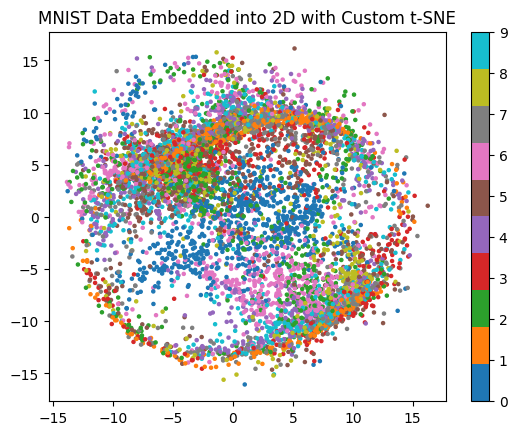

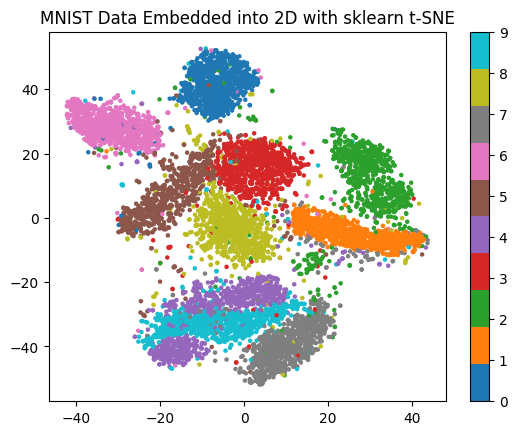

In [93]:
N = 400

# Run your custom t-SNE implementation
custom_tsne = CustomTSNE(n_components=2, n_iter=1000, perplexity=N/3)
custom_Y = custom_tsne.fit_transform(X_train_normalized_opt1)

# Run sklearn t-SNE
sk_tsne = TSNE(n_components=2, init='random', perplexity=N/3)
sk_Y = sk_tsne.fit_transform(X_train_normalized_opt1)

# Visualization of the result
plt.figure()
plt.scatter(custom_Y[:, 0], custom_Y[:, 1], s=5, c=label_train.astype(int), cmap='tab10')
plt.colorbar()
plt.title('MNIST Data Embedded into 2D with Custom t-SNE')
plt.show()

plt.figure()
plt.scatter(sk_Y[:, 0], sk_Y[:, 1], s=5, c=label_train.astype(int), cmap='tab10')
plt.colorbar()
plt.title('MNIST Data Embedded into 2D with sklearn t-SNE')
plt.show()

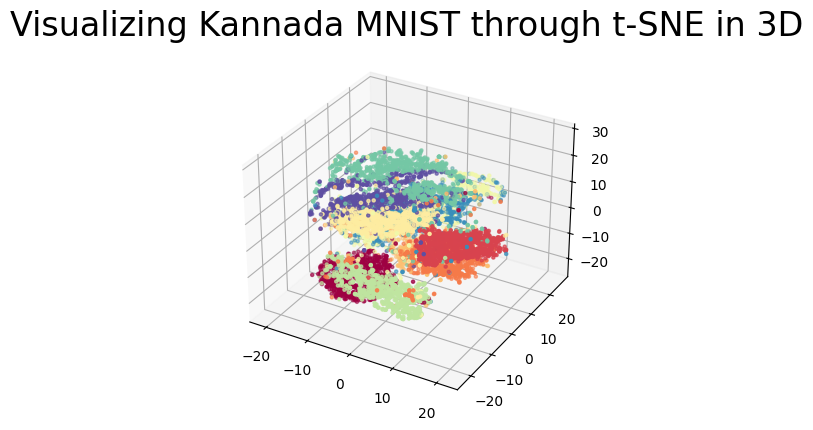

In [10]:
# Run sklearn t-SNE
sk_tsne_3d = TSNE(n_components=3, init='random', perplexity=N/10)
sk_Y_3d = sk_tsne_3d.fit_transform(X_train_normalized_opt2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(sk_Y_3d[:, 0], sk_Y_3d[:, 1],sk_Y_3d[:,2], s= 5, c=label_train, cmap='Spectral')
plt.title('Visualizing Kannada MNIST through t-SNE in 3D', fontsize=24);
plt.show()

# t-SNE extension - mapping new samples
Demonstrate your t-SNE transformation procedure.

Add plots and figures.

Please use the cell below t describe your suggested approach in detail. Use formal notations where appropriate.
Describe and discuss your results.

Text(0.5, 1.0, 'MNIST Data Embedded into 2D with Custom t-SNE')

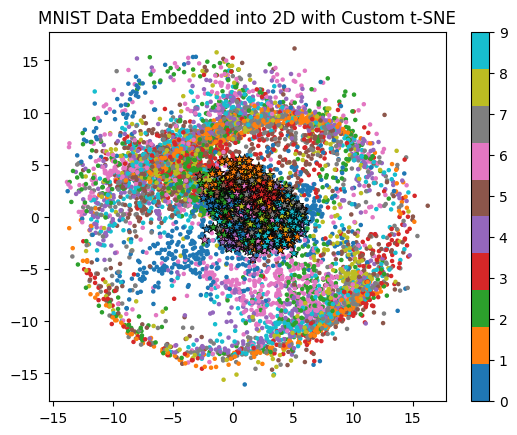

In [119]:
# Transform new data
custom_Y_new = custom_tsne.transform(X_train_normalized_opt1,custom_Y,X_test)

# Visualization of the result
plt.figure()
plt.scatter(custom_Y[:, 0], custom_Y[:, 1], s=5, c=label_train.astype(int), cmap='tab10')
plt.scatter(custom_Y_new[:, 0], custom_Y_new[:, 1], marker = '*', s=50, linewidths=0.5, edgecolors='k', c=label_test.astype(int), cmap='tab10')
plt.colorbar()
plt.title('MNIST Data Embedded into 2D with Custom t-SNE')

# Use of generative AI
Please use the cell below to describe your use of generative AI in this assignment. 